# 模型验证与测试、超参选择、模型选择

在这一节中，我们会探索 *模型评估* 和对 *超参数* 的调整，所谓超参数就是模型初始化时人工设置的参数。

In [1]:
from __future__ import print_function, division

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Use seaborn for plotting defaults
import seaborn as sns; sns.set()

## 验证模型

机器学习最重要的一部分之一就是**模型验证**：也就是，看看你训练出来的模型与给定的数据集是否相配。但是这里有几点是需要注意的。

我们回想一下我们之前看过的数字的例子，我们如何去评判一个模型的好坏呢？

In [2]:
from sklearn.datasets import load_digits
import sklearn.datasets

my_dataset = sklearn.datasets.load_breast_cancer()
X = my_dataset.data
y = my_dataset.target

让我们初始化一个K-neighbors分类器

In [3]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=1)

现在让我们用这个分类器去预测数字对应的标签

In [4]:
y_pred = knn.predict(X)

最后，我们可以看一看训练模型的效果：

In [5]:
print("{0} / {1} correct".format(np.sum(y == y_pred), len(y)))

569 / 569 correct


结果似乎表明我们有了一个完美的分类器！

**问题：错误究竟在哪里？**

## 测试集

上面我们的错误之处在于，我们在训练集上去测试我们的数据。**通常来说这不是一个好方法**。如果我们按照这种方式去优化estimator的时候，往往我们会得到**过拟合**的结果，也就是说，我们在训练时把数据的噪声也学进去了。

测试模型的一个好方法就是用未曾训练过的数据作为测试集。我们在scikit-learn的测试/训练集合划分中已经掌握了这个思想了。

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)  #(default=0.25)
X_train.shape, X_test.shape

((426, 30), (143, 30))

参数解释：

　    　train_data：所要划分的样本特征集

　    　train_label：所要划分的样本类别

　    　test_size：样本占比，如果是整数的话就是样本的数量.(注意：)

                   --  test_size:测试样本占比。 默认情况下，该值设置为0.25。 默认值将在版本0.21中更改。 只有train_size没有指定时， 

                        它将保持0.25，否则它将补充指定的train_size，例如train_size=0.6,则test_size默认为0.4。

                   -- train_size:训练样本占比。

　    　random_state：是随机数的种子。

　　    随机数种子：其实就是该组随机数的编号，在需要重复试验的时候，保证得到一组一样的随机数。比如你每次都填1，其他参数一样的情况下你得到的随机数组是一样的。但填0或不填，每次都会不一样。随机数的产生取决于种子，随机数和种子之间的关系遵从以下两个规则：种子不同，产生不同的随机数；种子相同，即使实例不同也产生相同的随机数

现在我们在训练集上进行训练，在测试集上进行验证：

In [7]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("{0} / {1} correct".format(np.sum(y_test == y_pred), len(y_test)))

126 / 143 correct


它给了我们一个对于模型的好坏更可信的估计。

我们这里使用的验证方法，也就是看正确个数之于总样本个数的方法，叫做**正确率**，而且我们可以使用以下的代码得到它：

In [8]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.8811188811188811

我们也可以通过``model.score``方法直接计算出来：

In [9]:
knn.score(X_test, y_test)

0.8811188811188811

## 验证集

- 训练集（train set） —— 用于模型拟合的数据样本。
- 验证集（development set）—— 是模型训练过程中单独留出的样本集，它可以用于调整模型的超参数和用于对模型的能力进行初步评估。
       在普通的机器学习中常用的交叉验证（Cross Validation) 就是把训练数据集本身再细分成不同的验证数据集去训练模型。

- 测试集 —— 用来评估模最终模型的泛化能力。但不能作为调参、选择特征等算法相关的选择的依据。

![Data Layout](img/yanzheng.png)

一个形象的比喻：

    训练集-----------学生的课本；学生 根据课本里的内容来掌握知识。

    验证集------------作业，通过作业可以知道 不同学生学习情况、进步的速度快慢。

    测试集-----------考试，考的题是平常都没有见过，考察学生举一反三的能力。

传统上，一般三者切分的比例是：6：2：2，验证集并不是必须的。

 ![Data Layout](img/cross.png)

## 交叉验证

 交叉验证法的作用就是尝试利用不同的训练集/验证集划分来对模型做多组不同的训练/验证，来应对单独测试结果过于片面以及训练数据不足的问题。


##### k折交叉验证的过程

第一步我们使用不重复抽样将原始数据(训练数据)随机分为k份，

第二步 k-1份数据用于模型训练，剩下那一份数据用于验证模型。

然后重复第二步k次，我们就得到了k个模型和他的评估结果(译者注：为了减小由于数据分割引入的误差，通常k折交叉验证要随机使用不同的划分方法重复p次，常见的有10次10折交叉验证)。

然后我们计算k折交叉验证结果的平均值作为参数/模型的性能评估。使用k折交叉验证来寻找最优参数要比holdout方法更稳定。

**一旦我们找到最优参数，要使用这组参数在全体训练数据集上训练模型作为最终的模型。**

In [11]:
from sklearn.model_selection import train_test_split,cross_val_score
for n_neighbors in [1, 5, 10, 20, 30]:
    cv = cross_val_score(KNeighborsClassifier(n_neighbors), X_train,y_train, cv=10)
    print(n_neighbors,cv.mean())
   

1 0.9223698781838318
5 0.9318936877076412
10 0.9318936877076412
20 0.936655592469546
30 0.9225359911406423


In [13]:
#选择 n_neighbors=20
knn1=KNeighborsClassifier(10)   
knn1.fit( X_train,y_train) #重新在全体训练集训练，获得最终模型
knn1.score(X_test,y_test)  #测试集上测试， 与 n_neighbors=1 时0.916083916083916 比要好

0.916083916083916

它让更清楚的让我们了解了自己模型的性能。

## 超参选择 网格搜索

网格grid搜索： 将所有超参数组合全部训练、验证一遍，来比较一个最好的

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics
tuned_parameters={'n_neighbors':[1,5,10,20,30]}
 
knn2=GridSearchCV(KNeighborsClassifier(),tuned_parameters,cv=10)
knn2.fit(X_train,y_train)  #使用全部数据交叉验证  选择 超参数，和上面结果一样
print('Best parameters set found:',knn2.best_params_)

#选择完超参数，再在测试集上评价其效果
print(classification_report(y_test,knn2.predict(X_test))) 
print(metrics.confusion_matrix(y_test,knn2.predict(X_test))) 

Best parameters set found: {'n_neighbors': 20}
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        54
           1       0.91      0.97      0.93        89

    accuracy                           0.92       143
   macro avg       0.92      0.90      0.91       143
weighted avg       0.92      0.92      0.91       143

[[45  9]
 [ 3 86]]


In [19]:
#RandomizedSearchCV  会采用概率的方法，每次随机选择一个最合适的参数来试，
#当候选参数集合很大时，总的尝试的次数会比gridsearchcv少很多

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics
tuned_parameters={'n_neighbors':[1,5,10,20,30,40,50,60,70,80,100]} 
#这里不能是列表，有的版本有问题

clf=RandomizedSearchCV(KNeighborsClassifier(),tuned_parameters,cv=5,scoring='accuracy',n_iter=4) 

clf.fit(X_train,y_train)
print('Best parameters set found:',clf.best_params_)
 
print(classification_report(y_test,clf.predict(X_test))) 
print(metrics.confusion_matrix(y_test,clf.predict(X_test)))


Best parameters set found: {'n_neighbors': 10}
              precision    recall  f1-score   support

           0       0.90      0.87      0.89        54
           1       0.92      0.94      0.93        89

    accuracy                           0.92       143
   macro avg       0.91      0.91      0.91       143
weighted avg       0.92      0.92      0.92       143

[[47  7]
 [ 5 84]]


In [20]:
#使用svm尝试
#下面的随机搜索 需要 sklearn高版本支持，如果遇到问题，需要升级sklearn
#RandomizedSearchCV  会采用概率的方法，每次随机选择一个最合适的参数来试，
#当候选参数集合很大时，总的尝试的次数会比gridsearchcv少很多

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics

from sklearn.svm import SVC  
tuned_parameters={'C':[0.01,0.1,1,10,100],'kernel':['rbf','linear']}

clf=RandomizedSearchCV(SVC(),tuned_parameters,cv=5,scoring='accuracy',n_iter=6) 

clf.fit(X_train,y_train)
print('Best parameters set found:',clf.best_params_)
 
print(classification_report(y_test,clf.predict(X_test))) 
print(metrics.confusion_matrix(y_test,clf.predict(X_test)))


Best parameters set found: {'kernel': 'linear', 'C': 100}
              precision    recall  f1-score   support

           0       0.96      0.91      0.93        54
           1       0.95      0.98      0.96        89

    accuracy                           0.95       143
   macro avg       0.95      0.94      0.95       143
weighted avg       0.95      0.95      0.95       143

[[49  5]
 [ 2 87]]


## 过拟合，欠拟合和模型选择

现在我们对验证以及交叉验证的基础知识都有了一定的了解，我们可以深入的探索模型选择的问题了。

验证和交叉验证是机器学习实践中的最重要的方面之一。如何对模型进行选择也是很重要的，但是这一点恰恰被一些进入机器学习领域的新手所忽略。

下面一些问题十分的重要：

**如果我们的estimator不能很好的工作，我们接下来应该怎么办呢？**

- 使用更简单的或者更复杂的模型？
- 给模型添加更多的特征？
- 添加更多的训练数据？

这个答案经常是违反直觉的。特别的，**有时候一个复杂的模型会给出一个 _差_ 的结果**。同时，**有时候添加训练数据的个数并不会提升你的结果**。区分成功的机器学习领域的练习者与不成功的，就是选择方法去提高模型效果的能力。

### 关于偏置和方差取舍的说明

在这一个小节中，我们将讨论一个简单的一维的回归问题。这个例子会让我们清楚直观地看到我们的数据和模型，结果可以简单的扩展到高维数据。我们来看一看 **线性回归** 的问题。我们可以用scikit-learn的`sklearn.linear_model`模块来完成这个功能。

我们创造一个简单的非线性函数供我们拟合：

In [21]:
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

让我们把数据集画出来：

In [22]:
def make_data(N=40, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

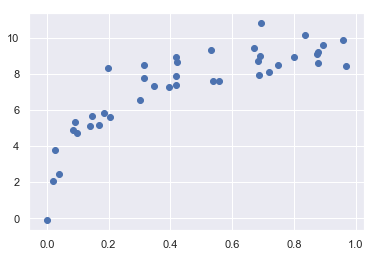

In [23]:
X, y = make_data(40, error=1)
plt.scatter(X.ravel(), y);

现在我们想在这个数据集中做回归预测。我们用集成的线性回归方法去处理一下：

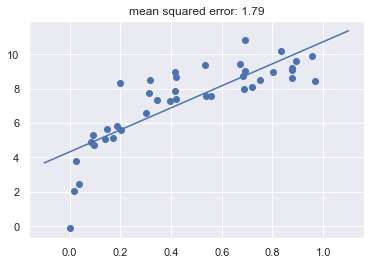

In [24]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

我们用一条直线去拟合了这一组数据，但是很明显这个模型并不是一个好的选择。这个模型对数据的拟合有**偏差**，也就是这个模型是**欠拟合**的。

让我去用更复杂的模型去提升效果。我们可以增加模型的自由度，用一个多项式级别的回归去预测我们的模型。Scikit-learn通过``PolynomialFeatures``处理器让预测变的特别简单。

它是使用多项式的方法来进行的，如果有a，b两个特征，那么它的2次多项式为（1,a,b,a^2,ab, b^2），这个多项式的形式是使用poly的效果。

我们用一个简单的方法去做：

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

现在我们用一个二次曲线去拟合这个数据：

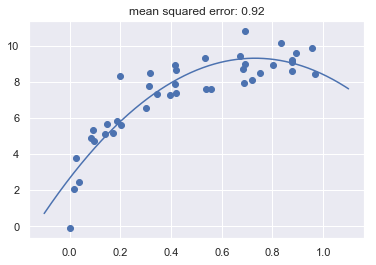

In [26]:
model = PolynomialRegression(2)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

现在的这个拟合减少了均方差，而且比之前的拟合更优。如果我们选取更高维的多项式会有什么结果呢？

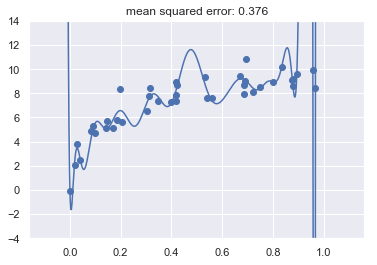

In [27]:
model = PolynomialRegression(30)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))
plt.ylim(-4, 14);

当我们将多项式的维度提高到这个程度的时候，很明显这个结果已经不再能良好的体现出数据的分布了，它对数据中的噪声变的很敏感。因此，我们叫它高方差模型，也就是说这个模型过拟合了。

### 通过验证曲线检测过拟合

在训练集上计算出错误显然是不够的。我们可以使用**交叉验证**的方式更好的去看一看这个模型的优劣。

我们在这里也使用``validation_curve``这个工具。为了弄明白，我们用一个稍微大一点的数据集：

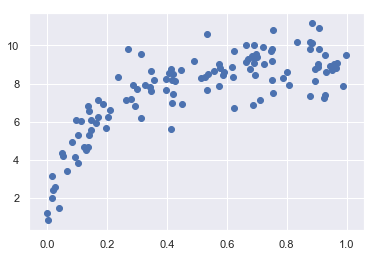

In [28]:
X, y = make_data(120, error=1.0)
plt.scatter(X, y);

In [29]:
from sklearn.model_selection import validation_curve

def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

degree = np.arange(0, 18)
val_train, val_test = validation_curve(PolynomialRegression(), X, y,
                                       'polynomialfeatures__degree', degree, cv=7,
                                       scoring=rms_error)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass param_name=polynomialfeatures__degree, param_range=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


我们现在画出验证曲线：

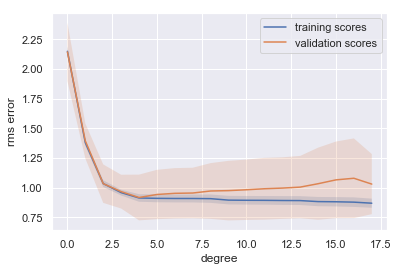

In [30]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(degree, val_train, label='training scores')
plot_with_err(degree, val_test, label='validation scores')
plt.xlabel('degree'); plt.ylabel('rms error')
plt.legend();

注意曲线的趋势，这对于这种类型的图来说很正常。

1. 对于低复杂度的模型而言，训练集上的错误率和验证集上的错误率非常的类似。这说明现在模型是**欠拟合**：它目前的复杂度不具备完好表达数据分布的能力。换个角度来说，这个模型称为**高偏置**的模型.

2. 当模型的复杂度增加的时候，训练集和验证集上的错误率开始分离开来。这表明这个模型已经**过拟合**了，它过于复杂以至于它对数据中的噪声过于敏感了。换个角度来说，这个模型称为**高方差**模型。

3. 我们需要注意到，训练的准确率几乎总是随着模型复杂度的提高而增加。这是因为越复杂的模型越能够学习噪声，所以训练的准确率会上升。验证数据通常有一个最佳位置，一般来说在度为5的时候最好。

在这里我们根据交叉验证，给出最佳拟合数据的模型：

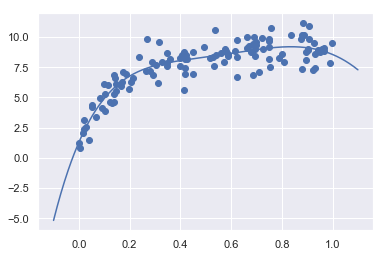

In [31]:
model = PolynomialRegression(5).fit(X, y)
plt.scatter(X, y)
plt.plot(X_test, model.predict(X_test));

## 总结

我们针对模型验证以及介绍了以下几种有用的方法

- **训练得分** 显示了模型在训练集上的训练效果，但这并不是模型适用性的评判标准。
- **验证得分** 显示了模型对于非训练集的数据的拟合效果。最有效的方法是，用非训练集以外的验证数据集进行交叉验证。

- **验证曲线** 是以模型复杂度为参数的训练集得分和验证集得分的曲线：
     + 当两个曲线相近的时候，代表*欠拟合* 
     + 当两个曲线逐渐分开的时候，代表*过拟合* 
     + "最佳位置"在曲线的中间 

    
这些方法在您评估一个模型的时候会非常有用。

## 进一步看一下算法分类选择


![Data Layout](img/suanfa.jpg)


还要多看sklearn那个模型选择导图
![Data Layout](img/daotu.png)